In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [9]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karthur10","key":"fc46f80c4dca86f552ee6bf9abe70b80"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [11]:
!kaggle competitions download -c tensorflow-speech-recognition-challenge

100% 2.45G/2.46G [00:42<00:00, 79.3MB/s]
100% 2.46G/2.46G [00:44<00:00, 59.8MB/s]
 99% 1.03G/1.04G [00:18<00:00, 49.9MB/s]
100% 1.04G/1.04G [00:18<00:00, 61.3MB/s]
  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 55.5MB/s]
  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 42.1kB/s]


In [12]:
!sudo apt install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [13]:
ls

kaggle.json                   sample_submission.7z  train.7z
link_to_gcp_credits_form.txt  test.7z


In [14]:
!p7zip -d train.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio/_background_noise_/pink_noise.wav                                                         0% 70 - train/audio/bed/042186b8_nohash_0.wav

In [15]:
!p7zip -d sample_submission.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 512684 bytes (501 KiB)

Extracting archive: sample_submission.7z
--
Path = sample_submission.7z
Type = 7z
Physical Size = 512684
Headers Size = 146
Method = LZMA2:6m
Solid = -
Blocks = 1

  0%    Everything is Ok

Size:       4280538
Compressed: 512684


In [16]:
import torch
import sys
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import librosa
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
import librosa.display

from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split

print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
#! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
#print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
#print ('Current cuda device ', torch.cuda.current_device())

import numpy
import numpy as np

use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

import pandas
import pandas as pd

import logging
handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)
%matplotlib inline

# !pip install psutil
import psutil
import os
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()

__Python VERSION: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
__pyTorch VERSION: 1.3.1
__CUDA VERSION
__CUDNN VERSION: 7603
__Number CUDA Devices: 1
__Devices
Available devices  1
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
12.7
svmem(total=13655232512, available=12641480704, percent=7.4, used=710778880, free=676708352, active=783888384, inactive=11445014528, buffers=76402688, cached=12191342592, shared=921600, slab=604643328)
memory GB: 0.3680229187011719


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

In [0]:
DATA_ROOT =''
IMG_PATH  = DATA_ROOT + '/train/pict/'
IMG_EXT = '.png'
IMG_DATA_LABELS = DATA_ROOT + '/train_v2.csv'

In [0]:
audio_path = '/root/train/audio/'
pict_Path = '/root/train/pict/'
test_pict_Path = '/root/test/pict/'
test_audio_path = '/root/test/audio/'

In [0]:
samples = []

if not os.path.exists(pict_Path):
    os.makedirs(pict_Path)

if not os.path.exists(test_pict_Path):
    os.makedirs(test_pict_Path)
    
subFolderList = []

for x in os.listdir(audio_path):
    if os.path.isdir(audio_path + '/' + x):
        subFolderList.append(x)
        if not os.path.exists(pict_Path + '/' + x):
            os.makedirs(pict_Path +'/'+ x)

In [33]:
%cd /.kaggle/train/pict/train
!ls

/.kaggle/train/pict/train
audio  LICENSE	README.md  testing_list.txt  validation_list.txt


In [1]:
#### Function: convert audio to spectogram images
import soundfile as sf
from matplotlib import pyplot as plt

def wav2img(wav_path, targetdir='', figsize=(4,4)):
    """
    takes in wave file path
    and the fig size. Default 4,4 will make images 288 x 288
    """
    fs = 44100 # sampling frequency
    
    # use soundfile library to read in the wave files
    test_sound, samplerate = sf.read(wav_path)
    
    # make the plot
    fig = plt.figure(figsize=figsize)
    S, freqs, bins, im = plt.specgram(test_sound, NFFT=1024, Fs=samplerate, noverlap=512)
    plt.show
    plt.axis('off')
    
    ## create output path
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    plt.savefig('%s.png' % output_file)
    plt.close()


def wav2img_waveform(wav_path, targetdir='', figsize=(4,4)):
    test_sound, samplerate = sf.read(sample_audio[0])
    fig = plt.figure(figsize=figsize)
    plt.plot(test_sound)
    plt.axis('off')
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    plt.savefig('%s.png' % output_file)
    plt.close()

### Convert Training Audio
#### Loop through source audio and save as pictures 
# (may take a while) may also consider running at commandline. 
# Code is limited to 3 folders and 10 files each, get rid of array limits to process the entire directory

# c:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7221: RuntimeWarning: divide by zero encountered in log10
#   Z = 10. * np.log10(spec)

for i, x in enumerate(subFolderList[6:-3]):
    print(i, ':', x)
    # get all the wave files
    all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
    for j,file in enumerate(all_files):
        if j%100 == 0:
            print(f'Done for {j} out of {len(all_files)}.')
        try:
            wav2img(audio_path + x + '/' + file, pict_Path + x)                
        except Exception:
            print('Missed')

NameError: ignored

In [0]:
train_audio_path = audio_path
filename = 'wow/4a0e2c16_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
ipd.Audio(samples, rate=sample_rate)

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import defaultdict
d = defaultdict(LabelEncoder)

# Build the pictures path
subFolderList = []
for x in os.listdir(pict_Path):
    if os.path.isdir(pict_Path + '/' + x):
        subFolderList.append(x)        
            
good_labels=['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()

# print (type(POSSIBLE_LABELS))
# print (type(good_labels))
columns = ['img', 'label-str','fullpath']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
# df_pred.id.astype(int)

for i, x in enumerate(subFolderList):
    if (x in POSSIBLE_LABELS):
    #     print(i, ':', x)
        # get all the wave files
        all_files = [y for y in os.listdir(pict_Path + x) if '.png' in y]
        for file in all_files:
    #         print (audio_path + x + '/' + file, pict_Path + x)
            fullPath=pict_Path + x + '/' + file
    #         print (fullPath)
            df_pred = df_pred.append({'img':file, 'label-str':x,'fullpath':fullPath},ignore_index=True)
    #         print (pict_Path + x)    
    

# Encode the categorical labels as numeric data
df_pred['label'] = LabelEncoder().fit_transform(df_pred['label-str'])
# Make sure we dont save the header
df_pred.to_csv(IMG_DATA_LABELS, columns=('img','label-str','fullpath', 'label'), index=None, header=False)
df_pred.to_csv(IMG_DATA_LABELS +'_header', columns=('img','label-str','fullpath', 'label'), index=None, header=True)
    
df_pred.head(3)

,img,label-str,fullpath,label
0,00176480_nohash_0.png,down,G:/tensorflow-speech-recognition-challenge/tra...,0
1,004ae714_nohash_0.png,down,G:/tensorflow-speech-recognition-challenge/tra...,0
2,00b01445_nohash_0.png,down,G:/tensorflow-speech-recognition-challenge/tra...,0


In [0]:
import time
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from collections import defaultdict
d = defaultdict(LabelEncoder)

def encode_onehot(df, cols):  
    vec = DictVectorizer()    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

try:
    from PIL import Image
except ImportError:
    import Image
    
class GenericImageDataset(Dataset):    

    def __init__(self, csv_path, img_path, img_ext, transform=None):
        
        t = time.time()        
        lgr.info('CSV path {}'.format(csv_path))
        lgr.info('IMG path {}'.format(img_path))        
        
        assert img_ext in ['.png']
        
        tmp_df = pd.read_csv(csv_path, header=None) # img,label,fullpath
                        
        self.mlb = MultiLabelBinarizer()
        self.img_path = img_path
        self.img_ext = img_ext
        self.transform = transform

        # Encoding the variables                
        lgr.info("DF CSV:\n" + str (tmp_df.head(3)))
                        
        self.X_train = tmp_df[2]        
        
        self.y_train = self.mlb.fit_transform(tmp_df[1].str.split()).astype(np.float32)           
        self.y_train=self.y_train.reshape((self.y_train.shape[0]*10,1)) # Must be reshaped for PyTorch!                
        
#         y_df = encode_onehot(tmp_df, cols=[tmp_df[1]])
#         self.y_train = y_df 
        
        lgr.info('y_train {}'.format(self.y_train))
                
#         self.y_train = tmp_df[3].astype(np.float32)                          
#         self.y_train = self.mlb.fit_transform(tmp_df[1].str.split()).astype(np.float32)
#         self.y_train = tmp_df[3].astype(np.float32)       
#         d = defaultdict(LabelEncoder)
#         self.y_train =tmp_df[1].apply(lambda x: d[x].fit_transform(x))
    
#         tmp_df=one_hot(tmp_df,tmp_df[1])
#         self.y_train = tmp_df[1].astype(np.float32)       
#         encoder = LabelEncoder()
#         encoder.fit(tmp_df[1])
#         self.y_train = encoder.transform(tmp_df[1]).astype(np.float32)
#         self.y_train=self.y_train.reshape((self.y_train.shape[0],1)) # Must be reshaped for PyTorch!
                
        lgr.info('[*]Dataset loading time {}'.format(time.time() - t))
        lgr.info('[*] Data size is {}'.format(len(self)))
        
        lgr.info("DF CSV:\n" + str (tmp_df.head(5)))
        
        print ()

    def __getitem__(self, index):
#         lgr.info ("__getitem__:" + str(index))
        path=self.img_path + self.X_train[index]
        path=self.X_train[index]
#         lgr.info (" --- get item path:" + path)
        img = Image.open(path)
        img = img.convert('RGB')
        if self.transform is not None: # TypeError: batch must contain tensors, numbers, or lists; 
                                     #found <class 'PIL.Image.Image'>
            img = self.transform(img)
#             print (str (type(img))) # <class 'torch.FloatTensor'>                
#         label = torch.from_numpy(self.y_train[index])
        label = (self.y_train[index])
        return img, label

    def __len__(self):
        l=len(self.X_train.index)
#         lgr.info ("Lenght:" +str(l))
        return (l)       

    @staticmethod        
    def imshow(img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

    @staticmethod    
    def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img    
    
    @staticmethod
    def toTensor(img):
        """convert a numpy array of shape HWC to CHW tensor"""
        img = img.transpose((2, 0, 1)).astype(np.float32)
        tensor = torch.from_numpy(img).float()
        return tensor/255.0  

In [0]:
transformations = transforms.Compose([transforms.ToTensor()])

In [0]:
dset_train = GenericImageDataset(IMG_DATA_LABELS,IMG_PATH,IMG_EXT,transformations)

INFO:__main__:CSV path G:/tensorflow-speech-recognition-challenge//train_v2.csv
INFO:__main__:IMG path G:/tensorflow-speech-recognition-challenge//train/train/pict/
INFO:__main__:DF CSV:
                       0     1  \
0  00176480_nohash_0.png  down   
1  004ae714_nohash_0.png  down   
2  00b01445_nohash_0.png  down   

                                                   2  3  
0  G:/tensorflow-speech-recognition-challenge/tra...  0  
1  G:/tensorflow-speech-recognition-challenge/tra...  0  
2  G:/tensorflow-speech-recognition-challenge/tra...  0  
INFO:__main__:y_train [[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]]
INFO:__main__:[*]Dataset loading time 0.1310265064239502
INFO:__main__:[*] Data size is 23682
INFO:__main__:DF CSV:
                       0     1  \
0  00176480_nohash_0.png  down   
1  004ae714_nohash_0.png  down   
2  00b01445_nohash_0.png  down   
3  00b01445_nohash_1.png  down   
4  00f0204f_nohash_0.png  down   

                                                   2  3  
0

In [0]:
batch_size = 16 # on GTX 1080
global_epoches = 10
LR = 0.0005
MOMENTUM = 0.95
validationRatio=0.11    

class FullTrainningDataset(torch.utils.data.Dataset):
    def __init__(self, full_ds, offset, length):
        self.full_ds = full_ds
        self.offset = offset
        self.length = length
        assert len(full_ds)>=offset+length, Exception("Parent Dataset not long enough")
        super(FullTrainningDataset, self).__init__()
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, i):
        return self.full_ds[i+self.offset]
    


def trainTestSplit(dataset, val_share=validationRatio):
    val_offset = int(len(dataset)*(1-val_share))
    print("Offest:" + str(val_offset))
    return FullTrainningDataset(dataset, 0, val_offset), FullTrainningDataset(dataset, val_offset, len(dataset)-val_offset)

 
train_ds, val_ds = trainTestSplit(dset_train)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print(train_loader)
print(val_loader)

Offest:21076


INFO:__main__:i=0: 
INFO:__main__:i=1: 
INFO:__main__:i=2: 
INFO:__main__:i=3: 


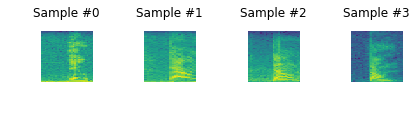

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

imagesToShow=4

for i, data in enumerate(train_loader, 0):
    lgr.info('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
    
    ax = plt.subplot(1, imagesToShow, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (GenericImageDataset.flaotTensorToImage(image))
        
    if i==imagesToShow-1:
        break    

In [0]:
dropout = torch.nn.Dropout(p=0.30)
class ConvRes(nn.Module):
    def __init__(self, insize, outsize):
        super(ConvRes, self).__init__()
        drate = .3
        self.math = nn.Sequential(
            nn.BatchNorm2d(insize),
            # nn.Dropout(drate),
            torch.nn.Conv2d(insize, outsize, kernel_size=2, padding=2),
            nn.PReLU(),
        )

    def forward(self, x):
        return self.math(x)


class ConvCNN(nn.Module):
    def __init__(self, insize, outsize, kernel_size=7, padding=2, pool=2, avg=True):
        super(ConvCNN, self).__init__()
        self.avg = avg
        self.math = torch.nn.Sequential(
            torch.nn.Conv2d(insize, outsize, kernel_size=kernel_size, padding=padding),
            torch.nn.BatchNorm2d(outsize),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(pool, pool),
        )
        self.avgpool = torch.nn.AvgPool2d(pool, pool)

    def forward(self, x):
        x = self.math(x)
        if self.avg is True:
            x = self.avgpool(x)
        return x


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d(1)

        self.cnn1 = ConvCNN(3, 32, kernel_size=7, pool=4, avg=False)
        self.cnn2 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)
        self.cnn3 = ConvCNN(32, 32, kernel_size=5, pool=2, avg=True)

        self.res1 = ConvRes(32, 64)

        self.features = nn.Sequential(
            self.cnn1, dropout,
            self.cnn2,
            self.cnn3,
            self.res1,
        )

        self.classifier = torch.nn.Sequential(
            nn.Linear(3136, 1),
        )
        self.sig = nn.Sigmoid()
  
    def forward(self, x):
        x = self.features(x)
#         print (x.data.shape)
        x = x.view(x.size(0), -1)
#         print (x.data.shape)
        x = self.classifier(x)
#         print (x.data.shape)
        x = self.sig(x)
        return x

    
if use_cuda:
    lgr.info ("Using the GPU")
    model = Net().cuda() # On GPU
else:
    lgr.info ("Using the CPU")
    model = Net() # On CPU

lgr.info('Model {}'.format(model))

INFO:__main__:Using the CPU
INFO:__main__:Model Net(
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (cnn1): ConvCNN(
    (math): Sequential(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=4, stride=4, padding=0)
  )
  (cnn2): ConvCNN(
    (math): Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (cnn3): ConvCNN(
    (math): Sequential(
      (0): Conv2d(32, 32, kernel_size=(

In [0]:
loss_func=torch.nn.BCELoss()
loss_func = nn.MultiLabelSoftMarginLoss()
# loss_func = torch.nn.CrossEntropyLoss()
# NN params
LR = 0.005
MOMENTUM= 0.9
optimizer = torch.optim.Adam(model.parameters(), lr=LR,weight_decay=5e-5) #  L2 regularization
if use_cuda:
    lgr.info ("Using the GPU")    
    model.cuda()
    loss_func.cuda()

lgr.info (optimizer)
lgr.info (loss_func)

INFO:__main__:Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 5e-05
)
INFO:__main__:MultiLabelSoftMarginLoss()


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
    
clf=model 
opt= optimizer
loss_history = []
acc_history = []
 
def train(epoch):
    clf.train() # set model in training mode (need this because of dropout)
     
    # dataset API gives us pythonic batching 
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if use_cuda:
            pass
            #data, target = Variable(data.cuda(async=True)), Variable(target.cuda(async=True)) # On GPU                
        else:            
            data, target = Variable(data), Variable(target) # RuntimeError: expected CPU tensor (got CUDA tensor)                           
                 
        # forward pass, calculate loss and backprop!
        opt.zero_grad()
        preds = clf(data)
        if use_cuda:
            loss = loss_func(preds, target).cuda()
#             loss = F.log_softmax(preds).cuda() # TypeError: log_softmax() takes exactly 1 argument (2 given)
#             loss = F.nll_loss(preds, target).cuda() # https://github.com/torch/cutorch/issues/227
            
        else:
            loss = loss_func(preds, target)
#             loss = F.log_softmax(preds)
#             loss = F.nll_loss(preds, target.long()) # RuntimeError: multi-target not supported at /pytorch/torch/lib/THNN/generic/ClassNLLCriterion.c:22
        loss.backward()
        
        opt.step()
        
        
        if batch_idx % 100 == 0:
            loss_history.append(loss.data)
            lgr.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data))              

            
start_time = time.time()    

for epoch in range(1, 5):
    print("Epoch %d" % epoch)
    train(epoch)    
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

Epoch 1


INFO:__main__:Train Epoch: 1 [0/21076 (0%)]	Loss: 0.693152
INFO:__main__:Train Epoch: 1 [1600/21076 (8%)]	Loss: 0.693154


KeyboardInterrupt: 

In [0]:
criterion = loss_func
all_losses = []
val_losses = []


if __name__ == '__main__':

    for epoch in range(global_epoches):
        print('Epoch {}'.format(epoch + 1))
        print('*' * 5 + ':')
        running_loss = 0.0
        running_acc = 0.0
        for i, data in enumerate(train_loader, 1):
    
            img, label = data
            if use_cuda:
                img, label = Variable(img.cuda(async=True)), Variable(label.cuda(async=True))  # On GPU
            else:
                img, label = Variable(img), Variable(
                    label)  # RuntimeError: expected CPU tensor (got CUDA tensor)
    
            out = model(img)
            loss = criterion(out, label)
            running_loss += loss.data * label.size(0)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if i % 100 == 0:
                all_losses.append(running_loss / (batch_size * i))
                print('[{}/{}] Loss: {:.6f}'.format(
                    epoch + 1, global_epoches, running_loss / (batch_size * i),
                    running_acc / (batch_size * i)))
                
    
#                 loss_cost = loss.data[0]                                
#                 # RuntimeError: can't convert CUDA tensor to numpy (it doesn't support GPU arrays). 
#                 # Use .cpu() to move the tensor to host memory first.        
#                 prediction = (model(img).data).float() # probabilities         
#         #         prediction = (net(X_tensor).data > 0.5).float() # zero or one
#         #         print ("Pred:" + str (prediction)) # Pred:Variable containing: 0 or 1
#         #         pred_y = prediction.data.numpy().squeeze()            
#                 pred_y = prediction.cpu().numpy().squeeze()
#                 target_y = label.cpu().data.numpy()

#                 tu = (log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
#                 print ('LOG_LOSS={}, ROC_AUC={} '.format(*tu))  
        
    
        print('Finish {} epoch, Loss: {:.6f}'.format(epoch + 1, running_loss / (len(train_ds))))
    
        model.eval()
        eval_loss = 0
        eval_acc = 0
        for data in val_loader:
            img, label = data
    
            if use_cuda:
                img, label = Variable(img.cuda(async=True), volatile=True),Variable(label.cuda(async=True), volatile=True)  # On GPU
            else:
                img = Variable(img, volatile=True)
                label = Variable(label, volatile=True)
    
            out = model(img)
            loss = criterion(out, label)
            eval_loss += loss.data * label.size(0)
    
        print('VALIDATION Loss: {:.6f}'.format(eval_loss / (len(val_ds))))
        val_losses.append(eval_loss / (len(val_ds)))
        print()